In [14]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)


CUDA available: True
Using device: cuda


In [15]:
base_dir = "data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
classes = ["cat", "dog", "panda"]


for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)


for folder in ["train", "test"]:
    for cls in classes:
        folder_path = os.path.join(base_dir, folder, cls)
        if len(os.listdir(folder_path)) == 0:
            for i in range(3):
                img = Image.fromarray(np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8))
                img.save(f"{folder_path}/{cls}_{i}.jpg")

print("Folders ready and dummy images added if needed.")


Folders ready and dummy images added if needed.


In [16]:

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
class_names = train_data.classes
print("Classes:", class_names)


Classes: ['cat', 'dog', 'panda']


In [17]:

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)
model = model.to(device)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - CrossEntropyLoss: {avg_loss:.4f}")


torch.save(model.state_dict(), "cat_dog_panda_model.pth")
print("Model saved successfully!")


Epoch [1/10] - CrossEntropyLoss: 0.9929
Epoch [2/10] - CrossEntropyLoss: 1.1129
Epoch [3/10] - CrossEntropyLoss: 1.2182
Epoch [4/10] - CrossEntropyLoss: 1.0554
Epoch [5/10] - CrossEntropyLoss: 1.2426
Epoch [6/10] - CrossEntropyLoss: 1.1816
Epoch [7/10] - CrossEntropyLoss: 1.1313
Epoch [8/10] - CrossEntropyLoss: 0.8025
Epoch [9/10] - CrossEntropyLoss: 1.0570
Epoch [10/10] - CrossEntropyLoss: 1.0360
Model saved successfully!


Test Accuracy: 33.33%


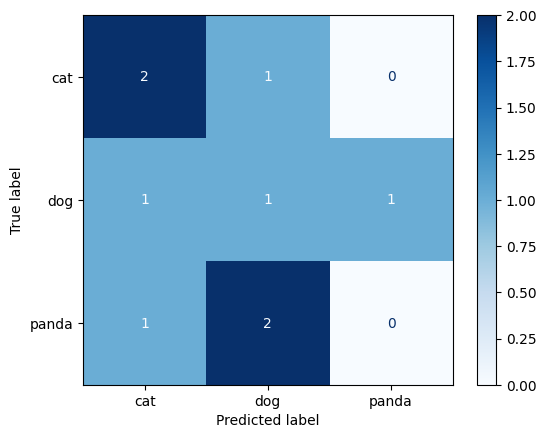

In [19]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100*sum(np.array(all_preds)==np.array(all_labels))/len(all_labels)
print(f"Test Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()


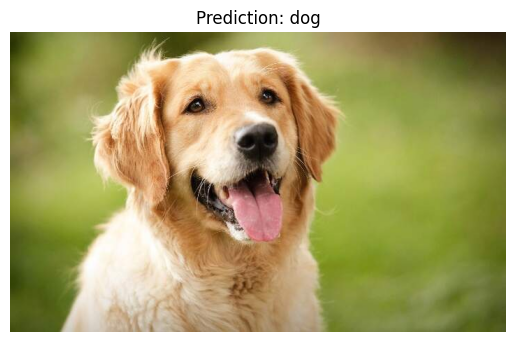

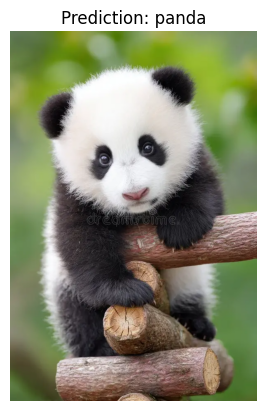

In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()


test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Map ImageNet predictions to simplified classes
dog_indices = list(range(151,269))  # all dog classes
panda_index = 388

def map_to_class_top5(pred_tensor):
    top5_prob, top5_idx = torch.topk(pred_tensor,5)
    top5_idx = top5_idx.cpu().numpy()[0]
    for idx in top5_idx:
        if idx in dog_indices:
            return "dog"
        if idx == panda_index:
            return "panda"
    return "cat"


def predict_and_show(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = test_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    predicted_label = map_to_class_top5(output)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

predict_and_show("C:/Users/admin/Downloads/dog.jpg")     # should output dog
predict_and_show("C:/Users/admin/Downloads/panda.png")   # should output panda
